In [2]:
from django.shortcuts import render
import re, io
from konlpy.tag import Twitter
from collections import Counter
import urllib, base64
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import requests
import time, datetime
from wordcloud import WordCloud
import os
import boto3
import pandas as pd
from io import StringIO
from pytz import timezone 


In [3]:
def read_data_from_s3(db_name):
    
    f = open("/home/ubuntu/Downloads/rootkey.txt", 'r')
    rootkey = f.read().splitlines()
    f.close()
    
    aws_id = rootkey[0]
    aws_secret = rootkey[1]
    
    bucket_name = 'web-novel-db'
    object_key = db_name
    client = boto3.client('s3',aws_access_key_id= aws_id, aws_secret_access_key=aws_secret)
    csv_obj = client.get_object(Bucket=bucket_name, Key=object_key)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')
    return pd.read_csv(StringIO(csv_string))

In [4]:
joara = read_data_from_s3('joara-tobe.csv')
bookpal = read_data_from_s3('bookpal-tobe.csv')
tocsoda_web = read_data_from_s3('tocsoda-tobe-web.csv')
tocsoda_free = read_data_from_s3('tocsoda-tobe-free.csv')

novel = pd.concat([joara,bookpal, tocsoda_web, tocsoda_free])

today = datetime.datetime.now(timezone('Asia/Seoul'))
start = today - datetime.timedelta(days = 6) 
end_day = int(today.strftime('%Y%m%d')) 
start_day = int(start.strftime('%Y%m%d')) 
novel = novel[(start_day <= novel['date']) & (novel['date'] <= end_day)]

In [5]:
def get_tags(data, ntags=50): #상위 50개만 추출
    hangul = re.compile('[^ a-zA-Z0-9ㄱ-ㅣ가-힣]+') 

    txt = ''

    data = data.title.values.tolist() + data.intro.tolist()
    
    for nov in data:
            if type(nov) != str:
                continue
            txt = txt + ' ' + nov
    
    cleaned_text = hangul.sub(' ', txt)
    spliter = Twitter()
    nouns = spliter.nouns(cleaned_text)
    nouns = [n for n in nouns if len(n) > 1] #한글자 단어 삭제 
    count = Counter(nouns)
    return_dict = {}
    
    for n, c in count.most_common(ntags):
        if n not in ['표지', '소설', '여주', '그녀', '사람', '연재', '무료', '신작']:
            return_dict[n] = c
    return return_dict

In [6]:

print(novel)

         date     genre                               title  \
460  20210113  [로맨스판타지]            여주 죽고 미친 남주의 친구입니다 <26편>   
461  20210113      [BL]                      힐, 힐, 힐! <56편>   
462  20210113     [패러디]  (fate / fgo)룰렛은 너의 지옥을 가.. <1078편>   
463  20210113      [BL]                 테디베어에게 안긴 햄스터 <26편>   
464  20210113  [로맨스판타지]           푸드 트럭 모는 아가씨는 어떤가요? <24편>   
..        ...       ...                                 ...   
615  20210119     [패러디]                    [하이큐] 건넛집 유카리씨!!   
616  20210119     [패러디]                          [원피스]리코일대기   
617  20210119     [패러디]        [패러디] [하이큐] 뱀파이어라도 배구가 하고싶어!   
618  20210119     [패러디]                    [원피스] Marine Ace   
619  20210119     [패러디]                     [해리포터] 그녀는 해리에요   

                                                 intro  
460  여주가 죽고 미친 남주의… 친구에 빙의했다. \r\n\r\n내 역할은 한 가지.\r...  
461  [캠퍼스물/게임에서 만나 연애까지/무용과X사진과]\r\n[미남공, 입덕부정공, 인성...  
462  표지의 룰렛이 이 소설의 시작이자 끝이자 만악의 근원입니다\r\n\r\n유열러 아닙...  
463  경계심 강하고 생활

In [7]:
w_keyword = get_tags(novel, 100)

/home/ubuntu/novel/lib/python3.6/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [8]:
def wordcloud(keyword):
	wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',  
            background_color='white', 
            width=900, 
            height=360, 
            max_words=100, 
            max_font_size=200, 
    	)

	try:
		wc_img = wc.generate_from_frequencies(keyword)
	except:
		return 'null'
	plt.figure(figsize=(12, 5))
	plt.imshow(wc_img, interpolation='bilinear')
	plt.axis("off")
	image = io.BytesIO()
	plt.savefig(image, format='png', bbox_inches='tight', pad_inches=0.1)
	image.seek(0)  
	string = base64.b64encode(image.read())
	image_64 = 'data:image/png;base64,' + urllib.parse.quote(string)
	return image_64

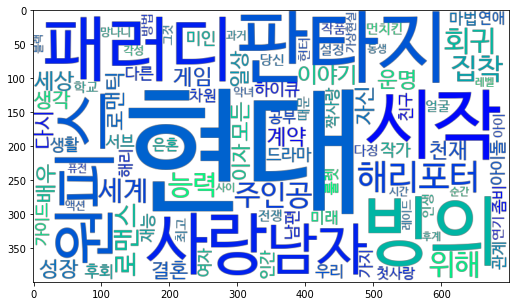

In [24]:
import random
import pytagcloud
random.random()
r = random.randrange(1,4) 

season = ['spring', 'summer', 'copper', 'winter']
wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',  
            mode = "RGBA", 
            background_color=None, 
            colormap = season[r], #가을
            width=700, 
            height=400, 
            max_words=100, 
            max_font_size=200, 
    	)

wc_img = wc.generate_from_frequencies(w_keyword)
#wc_img.to_file('./wordcloud.png')
plt.figure(figsize=(12, 5))
plt.imshow(wc_img, interpolation='bilinear')

dict

TypeError: can't multiply sequence by non-int of type 'float'